In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score
)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
import matplotlib.pyplot as plt
import shap

# 1. 读取与清洗数据
file_path =r'D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv'
df = pd.read_csv(file_path)

# 去除无关列 & 类型转换
df.drop(columns=[
    'Laser_Intensity', 'Hydraulic_Pressure_bar',
    'Coolant_Flow_L_min', 'Heat_Index'
], inplace=True)
for c in ['AI_Supervision', 'Failure_Within_7_Days']:
    df[c] = df[c].astype(int)
df['Machine_Type'] = LabelEncoder().fit_transform(df['Machine_Type'])

# 缺失值填充
for col in df.columns[df.isnull().any()]:
    df[col].fillna(df[col].median(), inplace=True)

# 2. IQR 异常值处理
def clip_iqr(data, cols):
    for col in cols:
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        data[col] = data[col].clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return data

num_feats = df.select_dtypes(include=np.number).columns.tolist()
for leak in ['Failure_Within_7_Days', 'Remaining_Useful_Life_days']:
    num_feats.remove(leak)
df = clip_iqr(df, num_feats)

# 3. 特征工程
df['Avg_Maintenance_Interval'] = df['Operational_Hours'] / (df['Maintenance_History_Count'] + 1)
df['Historical_Failure_Rate'] = df['Failure_History_Count'] / (df['Operational_Hours'] + 1)
df['Error_Code_Frequency'] = df['Error_Codes_Last_30_Days'] / 30
df['Maintenance_Frequency'] = df['Maintenance_History_Count'] / (df['Last_Maintenance_Days_Ago'] + 1)

# 4. 划分数据集
X = df.drop(columns=['Machine_ID', 'Remaining_Useful_Life_days', 'Failure_Within_7_Days'])
y = df['Failure_Within_7_Days']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

# 5. 标准化
scaler = StandardScaler()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_val_scaled = scaler.transform(X_val[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_df = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_val_df = pd.DataFrame(X_val_scaled, columns=num_cols, index=X_val.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# 6. 特征选择（基于 LightGBM 重要性）
sel_model = LGBMClassifier(random_state=42)
sel_model.fit(X_train_df, y_train)
selector = SelectFromModel(sel_model, threshold='median', prefit=True)
X_train_sel = selector.transform(X_train_df)
X_val_sel = selector.transform(X_val_df)
X_test_sel = selector.transform(X_test_df)

# 7. 过采样平衡
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sel, y_train)

# 8. 超参数调优函数
def tune_model(model_cls, param_space_func, X, y, n_trials=10):
    def objective(trial):
        params = param_space_func(trial)
        model = model_cls(**params)
        return cross_val_score(model, X, y, cv=3, scoring='roc_auc').mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

# 9. 定义调参空间
def xgb_space(trial):
    return {
        'objective': 'binary:logistic', 'eval_metric': 'auc',
        'n_jobs': -1, 'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
def lgb_space(trial):
    return {
        'random_state': 42, 'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }
def cat_space(trial):
    return {
        'random_seed': 42, 'verbose': 0,
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2)
    }

# 10. 执行调参
print("Tuning XGBoost...")
xgb_best_params = tune_model(XGBClassifier, xgb_space, X_train_res, y_train_res)
print("Tuning LGB...")
lgb_best_params = tune_model(LGBMClassifier, lgb_space, X_train_res, y_train_res)
print("Tuning CatBoost...")
cat_best_params = tune_model(CatBoostClassifier, cat_space, X_train_res, y_train_res)
print("Best Params:\nXGB", xgb_best_params, "\nLGB", lgb_best_params, "\nCAT", cat_best_params)

# 11. 单模型训练
models = {
    'xgb': XGBClassifier(**xgb_best_params),
    'lgb': LGBMClassifier(**lgb_best_params),
    'cat': CatBoostClassifier(**cat_best_params)
}
for name, mdl in models.items():
    mdl.fit(X_train_res, y_train_res)


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Number of positive: 15464, number of negative: 240536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2923
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060406 -> initscore=-2.744355
[LightGBM] [Info] Start training from score -2.744355


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
[I 2025-07-25 22:37:15,122] A new study created in memory with name: no-name-354e5168-3c5e-4b60-9dfe-25a80b66e1dc


Tuning XGBoost...


[I 2025-07-25 22:37:17,432] Trial 0 finished with value: 0.9875734136974145 and parameters: {'n_estimators': 249, 'learning_rate': 0.05021943180805836, 'max_depth': 4, 'subsample': 0.891703313231853, 'colsample_bytree': 0.6268017145574633}. Best is trial 0 with value: 0.9875734136974145.
[I 2025-07-25 22:37:19,016] Trial 1 finished with value: 0.9871948630470023 and parameters: {'n_estimators': 140, 'learning_rate': 0.08196251483538819, 'max_depth': 4, 'subsample': 0.8986191276403663, 'colsample_bytree': 0.6355474826097117}. Best is trial 0 with value: 0.9875734136974145.
[I 2025-07-25 22:37:21,327] Trial 2 finished with value: 0.9938915408456758 and parameters: {'n_estimators': 275, 'learning_rate': 0.1749697836962671, 'max_depth': 3, 'subsample': 0.7648493107576843, 'colsample_bytree': 0.6484425969433693}. Best is trial 2 with value: 0.9938915408456758.
[I 2025-07-25 22:37:28,417] Trial 3 finished with value: 0.9967919201519932 and parameters: {'n_estimators': 344, 'learning_rate': 0

Tuning LGB...
[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:37:55,356] Trial 0 finished with value: 0.996232164681509 and parameters: {'n_estimators': 338, 'learning_rate': 0.10851817080958948, 'num_leaves': 39, 'max_depth': 3}. Best is trial 0 with value: 0.996232164681509.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:37:57,216] Trial 1 finished with value: 0.9961236081468968 and parameters: {'n_estimators': 116, 'learning_rate': 0.1264282664778524, 'num_leaves': 95, 'max_depth': 6}. Best is trial 0 with value: 0.996232164681509.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:02,501] Trial 2 finished with value: 0.997718347804906 and parameters: {'n_estimators': 317, 'learning_rate': 0.07095683810089361, 'num_leaves': 85, 'max_depth': 10}. Best is trial 2 with value: 0.997718347804906.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:07,297] Trial 3 finished with value: 0.9890520039123727 and parameters: {'n_estimators': 360, 'learning_rate': 0.016918380472501306, 'num_leaves': 48, 'max_depth': 9}. Best is trial 2 with value: 0.997718347804906.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:11,508] Trial 4 finished with value: 0.9966049985131727 and parameters: {'n_estimators': 413, 'learning_rate': 0.051943726511466344, 'num_leaves': 93, 'max_depth': 5}. Best is trial 2 with value: 0.997718347804906.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:16,600] Trial 5 finished with value: 0.9977932671888085 and parameters: {'n_estimators': 361, 'learning_rate': 0.09826642853238277, 'num_leaves': 79, 'max_depth': 8}. Best is trial 5 with value: 0.9977932671888085.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:22,278] Trial 6 finished with value: 0.9962008734267057 and parameters: {'n_estimators': 469, 'learning_rate': 0.03161817128618892, 'num_leaves': 71, 'max_depth': 6}. Best is trial 5 with value: 0.9977932671888085.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:24,440] Trial 7 finished with value: 0.9889187302658194 and parameters: {'n_estimators': 252, 'learning_rate': 0.06007400721104407, 'num_leaves': 38, 'max_depth': 3}. Best is trial 5 with value: 0.9977932671888085.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:27,035] Trial 8 finished with value: 0.9973554202745931 and parameters: {'n_estimators': 284, 'learning_rate': 0.1789954285813881, 'num_leaves': 67, 'max_depth': 4}. Best is trial 5 with value: 0.9977932671888085.


[LightGBM] [Info] Number of positive: 160357, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160358, number of negative: 160357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 160357, number of negative: 160358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 320715, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-25 22:38:30,018] Trial 9 finished with value: 0.9973806602701615 and parameters: {'n_estimators': 281, 'learning_rate': 0.11745271209918721, 'num_leaves': 57, 'max_depth': 5}. Best is trial 5 with value: 0.9977932671888085.
[I 2025-07-25 22:38:30,019] A new study created in memory with name: no-name-36ae597b-d0f3-41fb-93e4-d07ada0c5553


Tuning CatBoost...


[I 2025-07-25 22:38:57,413] Trial 0 finished with value: 0.9979519381111573 and parameters: {'iterations': 428, 'depth': 8, 'learning_rate': 0.15705608522587247}. Best is trial 0 with value: 0.9979519381111573.
[I 2025-07-25 22:39:04,523] Trial 1 finished with value: 0.9880497636243705 and parameters: {'iterations': 152, 'depth': 6, 'learning_rate': 0.06060545837253968}. Best is trial 0 with value: 0.9979519381111573.
[I 2025-07-25 22:39:19,393] Trial 2 finished with value: 0.9954674759566999 and parameters: {'iterations': 339, 'depth': 3, 'learning_rate': 0.08189529008982084}. Best is trial 0 with value: 0.9979519381111573.
[I 2025-07-25 22:39:39,597] Trial 3 finished with value: 0.9890250610208348 and parameters: {'iterations': 436, 'depth': 4, 'learning_rate': 0.01960093269851018}. Best is trial 0 with value: 0.9979519381111573.
[I 2025-07-25 22:40:03,686] Trial 4 finished with value: 0.9901128743163227 and parameters: {'iterations': 464, 'depth': 6, 'learning_rate': 0.0127005240438

Best Params:
XGB {'n_estimators': 344, 'learning_rate': 0.19183175306917266, 'max_depth': 10, 'subsample': 0.8194949430201592, 'colsample_bytree': 0.759853959339136} 
LGB {'n_estimators': 361, 'learning_rate': 0.09826642853238277, 'num_leaves': 79, 'max_depth': 8} 
CAT {'iterations': 428, 'depth': 8, 'learning_rate': 0.15705608522587247}
[LightGBM] [Info] Number of positive: 240536, number of negative: 240536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 481072, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.4296917	total: 27.7ms	remaining: 11.8s
1:	learn: 0.3112275	total: 54.7ms	remaining: 11.6s
2:	learn: 0.2380468	total: 80.7ms	remaining: 11.4s
3

[LightGBM] [Info] Number of positive: 240536, number of negative: 240536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 481072, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.4296917	total: 27.9ms	remaining: 11.9s
1:	learn: 0.3112275	total: 56.6ms	remaining: 12.1s
2:	learn: 0.2380468	total: 84.7ms	remaining: 12s
3:	learn: 0.1950870	total: 111ms	remaining: 11.7s
4:	learn: 0.1662263	total: 136ms	remaining: 11.5s
5:	learn: 0.1515945	total: 161ms	remaining: 11.3s
6:	learn: 0.1402123	total: 184ms	remaining: 11.1s
7:	learn: 0.1347265	total: 208ms	remaining: 10.9s
8:	learn: 0.1289520	total: 232ms	remaining: 10.8s
9:	learn: 0.1255864	total: 256ms	remaining:

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


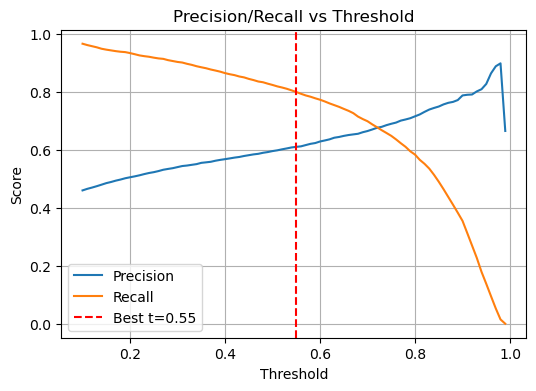

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[[72834  2334]
 [  956  3876]]
              precision    recall  f1-score   support

           0     0.9870    0.9689    0.9779     75168
           1     0.6242    0.8022    0.7020      4832

    accuracy                         0.9589     80000
   macro avg     0.8056    0.8856    0.8400     80000
weighted avg     0.9651    0.9589    0.9613     80000

ROC AUC: 0.9817451210612731

=== Blending ===


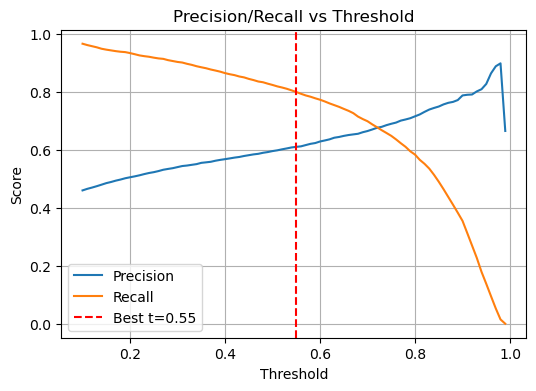

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[[72834  2334]
 [  956  3876]]
              precision    recall  f1-score   support

           0     0.9870    0.9689    0.9779     75168
           1     0.6242    0.8022    0.7020      4832

    accuracy                         0.9589     80000
   macro avg     0.8056    0.8856    0.8400     80000
weighted avg     0.9651    0.9589    0.9613     80000

ROC AUC: 0.9817451210612731

=== Stacking ===


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


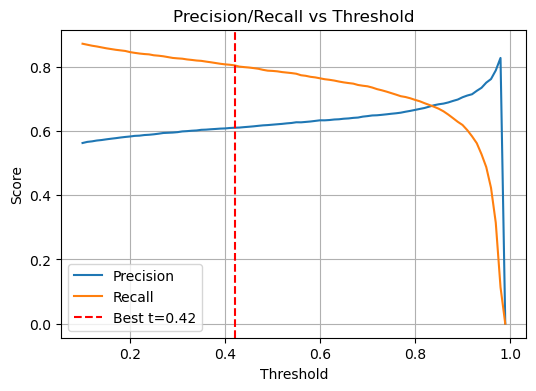

d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[[72742  2426]
 [  935  3897]]
              precision    recall  f1-score   support

           0     0.9873    0.9677    0.9774     75168
           1     0.6163    0.8065    0.6987      4832

    accuracy                         0.9580     80000
   macro avg     0.8018    0.8871    0.8381     80000
weighted avg     0.9649    0.9580    0.9606     80000

ROC AUC: 0.981488257142852

SHAP for Stacking final estimator:


ValueError: shapes (3,) and (10,) not aligned: 3 (dim 0) != 10 (dim 0)

In [2]:

# 12. Voting & Blending
voting = VotingClassifier(
    estimators=[(k, v) for k, v in models.items()],
    voting='soft'
)
voting.fit(X_train_res, y_train_res)

# Blending predictions
def blend_predict_proba(X):
    # 各模型正类概率的简单平均
    ps = np.column_stack([mdl.predict_proba(X)[:, 1] for mdl in models.values()])
    return ps.mean(axis=1)

# 定义一个 Blender 类，包装 blend_predict_proba
class Blender:
    def predict_proba(self, X):
        p = blend_predict_proba(X)
        # 返回形状 (n_samples, 2)，第一列为负类概率，第二列为正类概率
        return np.vstack([1 - p, p]).T

blender = Blender()

# 13. Stacking
stack = StackingClassifier(
    estimators=[(k, v) for k, v in models.items()],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train_res, y_train_res)

# 14. 阈值调优与可视化函数
def tune_threshold(model, X_val, y_val, recall_target=0.8):
    probs = model.predict_proba(X_val)[:, 1]
    ths = np.linspace(0.1, 0.99, 90)
    best = {'t': 0.5, 'p': 0}
    ps, rs = [], []
    for t in ths:
        preds = (probs >= t).astype(int)
        p = precision_score(y_val, preds)
        r = recall_score(y_val, preds)
        ps.append(p)
        rs.append(r)
        if r >= recall_target and p > best['p']:
            best = {'t': t, 'p': p}
    # 绘制 Precision/Recall vs Threshold
    plt.figure(figsize=(6, 4))
    plt.plot(ths, ps, label='Precision')
    plt.plot(ths, rs, label='Recall')
    plt.axvline(best['t'], color='red', linestyle='--', label=f"Best t={best['t']:.2f}")
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.title('Precision/Recall vs Threshold')
    plt.show()
    return best['t']

# 15. 评估所有模型
for name, mdl in [('Voting', voting), ('Blending', blender), ('Stacking', stack)]:
    print(f"\n=== {name} ===")
    # 在验证集上找到最优阈值
    best_t = tune_threshold(mdl, X_val_sel, y_val)
    # 测试集上预测
    if name == 'Blending':
        probs = blender.predict_proba(X_test_sel)[:, 1]
    else:
        probs = mdl.predict_proba(X_test_sel)[:, 1]
    preds = (probs >= best_t).astype(int)
    # 打印评估结果
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=4))
    print('ROC AUC:', roc_auc_score(y_test, probs))

# 16. SHAP 可解释性（针对 Stacking 的元模型）
print("\nSHAP for Stacking final estimator:")
explainer = shap.LinearExplainer(stack.final_estimator_, X_test_sel)
shap_values = explainer.shap_values(X_test_sel)
feature_names = np.array(X_train_df.columns)[selector.get_support()]
shap.summary_plot(shap_values, X_test_sel, feature_names=feature_names)

